### Preprocessing the Data for a Neural Network

In [186]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder,LabelEncoder
from keras.utils import np_utils
from config import db_password
import psycopg2
import pandas as pd
import tensorflow as tf

In [187]:
# Import and read csv
# import pandas as pd 
# kushy_washington_cleaned_df = pd.read_csv("./Data/kushy_washington_cleaned.csv")
# print(kushy_washington_cleaned_df.shape)
# kushy_washington_cleaned_df.head()

In [188]:
# Connect to sql database
con = psycopg2.connect(database='Medical-Marijuana-Group', user = 'postgres', password = db_password, host = '127.0.0.1', port = '5432')

# Create a new cursor
cur = con.cursor()

print('Opened database successfully')

Opened database successfully


In [189]:
# Create function that takes in a PostgreSQL query and outputs a Pandas dataframe
def create_pandas_df(sql_query, database = con):
    df = pd.read_sql_query(sql_query, database)
    return df
  
# Utilize the create_pandas_df function to create a Pandas dataframe
# Store the data as a variable
kushy_washington_cleaned_df = create_pandas_df('SELECT * FROM kushy_washington_cleaned')
print(kushy_washington_cleaned_df.shape)
kushy_washington_cleaned_df.head()

(722, 36)


,test_id,test_strain,type,ailment_1,ailment_2,ailment_3,ailment_4,ailment_5,effects_1,effects_2,...,inventory_type,chemotype,strain_leafly_page_rank,strain_leafly_review_rank,strain_tests,strain_chemotype,strain_prop_chemotype1,strain_prop_chemotype2,strain_prop_chemotype3,strain_modal_chemo_prop
0,19,Dutch Hawaiian,Sativa,Depression,Stress,Pain,Nausea,None,Happy,Energetic,...,Flower Lot,1,619,141,425,1,1.0,0.0,0.0,1.0
1,21,SleeStack,Hybrid,Stress,Depression,None,None,None,Uplifted,Euphoric,...,Flower Lot,1,1276,151,63,1,1.0,0.0,0.0,1.0
2,22,Space Needle,Sativa,Depression,Stress,None,None,None,Uplifted,Euphoric,...,Flower Lot,1,0,0,0,0,0.0,0.0,0.0,0.0
3,23,Double Purple Doja,Hybrid,Pain,Stress,Inflammation,Muscle Spasms,None,Relaxed,Creative,...,Flower Lot,1,1115,151,52,1,1.0,0.0,0.0,1.0
4,37,Jack Skellington,Hybrid,Stress,Depression,Pain,Muscle Spasms,None,Creative,Relaxed,...,Flower Lot,1,708,141,124,1,1.0,0.0,0.0,1.0


In [190]:
# Close the cursor and connection so the server can allocate bandwidth to other requests
cur.close()
con.close()
print('Closed database successfully')

Closed database successfully


In [191]:
# Drop non-beneficial identification columns
kushy_washington_df = kushy_washington_cleaned_df.drop(['test_id', 'test_strain'], axis=1)
print(kushy_washington_df.shape)
kushy_washington_df.head()

(722, 34)


,type,ailment_1,ailment_2,ailment_3,ailment_4,ailment_5,effects_1,effects_2,effects_3,effects_4,...,inventory_type,chemotype,strain_leafly_page_rank,strain_leafly_review_rank,strain_tests,strain_chemotype,strain_prop_chemotype1,strain_prop_chemotype2,strain_prop_chemotype3,strain_modal_chemo_prop
0,Sativa,Depression,Stress,Pain,Nausea,None,Happy,Energetic,Uplifted,Euphoric,...,Flower Lot,1,619,141,425,1,1.0,0.0,0.0,1.0
1,Hybrid,Stress,Depression,None,None,None,Uplifted,Euphoric,Creative,Relaxed,...,Flower Lot,1,1276,151,63,1,1.0,0.0,0.0,1.0
2,Sativa,Depression,Stress,None,None,None,Uplifted,Euphoric,Happy,Hungry,...,Flower Lot,1,0,0,0,0,0.0,0.0,0.0,0.0
3,Hybrid,Pain,Stress,Inflammation,Muscle Spasms,None,Relaxed,Creative,Sleepy,Happy,...,Flower Lot,1,1115,151,52,1,1.0,0.0,0.0,1.0
4,Hybrid,Stress,Depression,Pain,Muscle Spasms,None,Creative,Relaxed,Euphoric,Energetic,...,Flower Lot,1,708,141,124,1,1.0,0.0,0.0,1.0


In [192]:
# Determine number of unique values in each column
kushy_washington_df.nunique()

type                           4
ailment_1                      9
ailment_2                      9
ailment_3                     10
ailment_4                     10
ailment_5                      9
effects_1                     14
effects_2                     23
effects_3                     24
effects_4                     26
effects_5                     28
effects_6                      4
effects_7                      4
effects_8                      4
flavor_1                      32
flavor_2                      50
flavor_3                      42
ailment_count                  6
effects_count                  9
flavor_count                   4
thc_max                      697
cbd_max                      207
thc_cbd                      558
cbd_thc                       48
inventory_type                 7
chemotype                      3
strain_leafly_page_rank      640
strain_leafly_review_rank    128
strain_tests                 291
strain_chemotype               4
strain_pro

In [193]:
# Look at effects_1 value counts for binning
effects_1_counts = kushy_washington_df.effects_1.value_counts()
effects_1_counts

Relaxed      295
Happy        128
None         123
Euphoric      66
Uplifted      36
Energetic     28
Sleepy        13
Creative      10
Focused        6
Talkative      5
Horny          5
Tingly         3
Hungry         3
Giggly         1
Name: effects_1, dtype: int64

<AxesSubplot:ylabel='Density'>

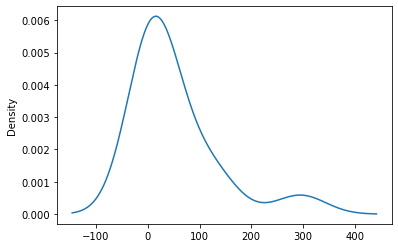

In [194]:
# Visualize the value counts of effects_1
effects_1_counts.plot.density()

In [195]:
# Determine which values to replace if counts are less than ...?
replace_effects_1 = list(effects_1_counts[effects_1_counts < 10].index)

# Replace in dataframe
for app in replace_effects_1:
    kushy_washington_df.effects_1 = kushy_washington_df.effects_1.replace(app,"Other")
    
# Check to make sure binning was successful
kushy_washington_df.effects_1.value_counts()

Relaxed      295
Happy        128
None         123
Euphoric      66
Uplifted      36
Energetic     28
Other         23
Sleepy        13
Creative      10
Name: effects_1, dtype: int64

In [196]:
# Look at effects_2 value counts for binning
effects_2_counts = kushy_washington_df.effects_2.value_counts()
effects_2_counts

 Happy        143
None          124
 Sleepy        90
 Euphoric      76
 Uplifted      66
 Relaxed       50
Happy          33
 Energetic     27
 Focused       22
Relaxed        19
 Creative      12
Euphoric       12
Uplifted       10
 Tingly         7
Sleepy          7
 Talkative      7
 Hungry         5
 Horny          4
Energetic       3
Focused         2
Hungry          1
Giggly          1
Creative        1
Name: effects_2, dtype: int64

<AxesSubplot:ylabel='Density'>

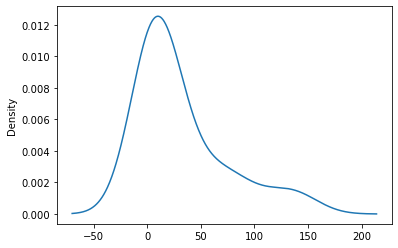

In [197]:
# Visualize the value counts of effects_3
effects_2_counts.plot.density()

In [198]:
# Determine which values to replace if counts are less than ...?
replace_effects_2 = list(effects_2_counts[effects_2_counts < 10].index)

# Replace in dataframe
for app in replace_effects_2:
    kushy_washington_df.effects_2 = kushy_washington_df.effects_2.replace(app,"Other")
    
# Check to make sure binning was successful
kushy_washington_df.effects_2.value_counts()

 Happy        143
None          124
 Sleepy        90
 Euphoric      76
 Uplifted      66
 Relaxed       50
Other          38
Happy          33
 Energetic     27
 Focused       22
Relaxed        19
 Creative      12
Euphoric       12
Uplifted       10
Name: effects_2, dtype: int64

In [199]:
# Look at effects_3 value counts for binning
effects_3_counts = kushy_washington_df.effects_3.value_counts()
effects_3_counts

None          125
 Happy        113
 Euphoric     100
 Uplifted      79
 Sleepy        46
 Relaxed       39
 Hungry        29
 Energetic     29
Euphoric       23
 Focused       21
 Creative      20
Uplifted       19
Relaxed        16
 Talkative     16
 Tingly        14
Happy          11
Giggly          5
Talkative       4
Energetic       3
Focused         3
 Horny          2
Hungry          2
Creative        2
Tingly          1
Name: effects_3, dtype: int64

<AxesSubplot:ylabel='Density'>

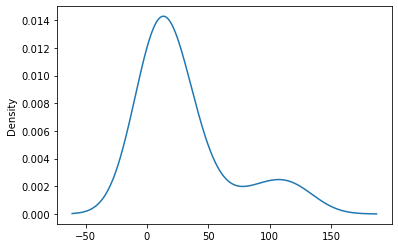

In [200]:
# Visualize the value counts of effects_3
effects_3_counts.plot.density()

In [201]:
# Determine which values to replace if counts are less than ...?
replace_effects_3 = list(effects_3_counts[effects_3_counts < 10].index)

# Replace in dataframe
for app in replace_effects_3:
    kushy_washington_df.effects_3 = kushy_washington_df.effects_3.replace(app,"Other")
    
# Check to make sure binning was successful
kushy_washington_df.effects_3.value_counts()

None          125
 Happy        113
 Euphoric     100
 Uplifted      79
 Sleepy        46
 Relaxed       39
 Hungry        29
 Energetic     29
Euphoric       23
Other          22
 Focused       21
 Creative      20
Uplifted       19
 Talkative     16
Relaxed        16
 Tingly        14
Happy          11
Name: effects_3, dtype: int64

In [202]:
# Look at effects_4 value counts for binning
effects_4_counts = kushy_washington_df.effects_4.value_counts()
effects_4_counts

None          128
 Euphoric     108
 Happy         70
 Uplifted      68
 Sleepy        51
 Creative      38
 Focused       34
 Hungry        32
 Energetic     31
 Relaxed       28
Uplifted       22
 Tingly        17
 Talkative     15
 Horny         14
Euphoric       11
Creative       11
Energetic       8
Hungry          7
Happy           7
Relaxed         7
Focused         6
Tingly          2
Aroused         2
Giggly          2
Talkative       2
Sleepy          1
Name: effects_4, dtype: int64

<AxesSubplot:ylabel='Density'>

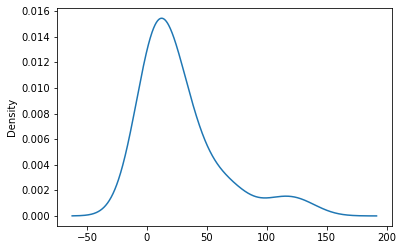

In [203]:
# Visualize the value counts of effects_4
effects_4_counts.plot.density()

In [204]:
# Determine which values to replace if counts are less than ...?
replace_effects_4 = list(effects_4_counts[effects_4_counts < 10].index)

# Replace in dataframe
for app in replace_effects_4:
    kushy_washington_df.effects_4 = kushy_washington_df.effects_4.replace(app,"Other")
    
# Check to make sure binning was successful
kushy_washington_df.effects_4.value_counts()

None          128
 Euphoric     108
 Happy         70
 Uplifted      68
 Sleepy        51
Other          44
 Creative      38
 Focused       34
 Hungry        32
 Energetic     31
 Relaxed       28
Uplifted       22
 Tingly        17
 Talkative     15
 Horny         14
Euphoric       11
Creative       11
Name: effects_4, dtype: int64

In [205]:
# Look at effects_5 value counts for binning
effects_5_counts = kushy_washington_df.effects_5.value_counts()
effects_5_counts

None          139
 Uplifted      92
 Euphoric      65
 Hungry        51
 Creative      48
 Dry Mouth     43
 Happy         36
 Energetic     28
 Sleepy        27
 Talkative     25
 Focused       23
 Relaxed       23
Creative       22
 Tingly        21
Euphoric       13
Uplifted       12
 Horny         10
Energetic       8
Sleepy          7
Hungry          6
Happy           5
Focused         4
Relaxed         3
Giggly          3
 Anxious        3
Tingly          2
Aroused         2
Talkative       1
Name: effects_5, dtype: int64

<AxesSubplot:ylabel='Density'>

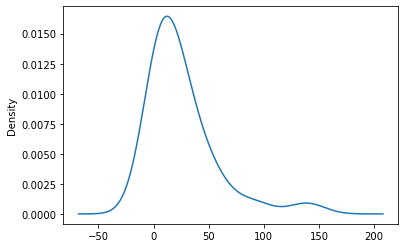

In [206]:
# Visualize the value counts of effects_5
effects_5_counts.plot.density()

In [207]:
# Determine which values to replace if counts are less than ...?
replace_effects_5 = list(effects_5_counts[effects_5_counts < 10].index)

# Replace in dataframe
for app in replace_effects_5:
    kushy_washington_df.effects_5 = kushy_washington_df.effects_5.replace(app,"Other")
    
# Check to make sure binning was successful
kushy_washington_df.effects_5.value_counts()

None          139
 Uplifted      92
 Euphoric      65
 Hungry        51
 Creative      48
Other          44
 Dry Mouth     43
 Happy         36
 Energetic     28
 Sleepy        27
 Talkative     25
 Focused       23
 Relaxed       23
Creative       22
 Tingly        21
Euphoric       13
Uplifted       12
 Horny         10
Name: effects_5, dtype: int64

In [208]:
# Look at flavor_1 value counts for binning
flavor_1_counts = kushy_washington_df.flavor_1.value_counts()
flavor_1_counts

Earthy          230
Sweet           112
None             90
Citrus           73
Berry            44
Pine             25
Lemon            22
Grape            18
Blueberry        16
Skunk            10
Pineapple         9
Strawberry        8
Lavender          6
Tropical          6
Pepper            6
Mango             6
Pungent           5
Diesel            5
Woody             4
Lime              4
Spicy/Herbal      3
Vanilla           3
Flowery           3
Cheese            3
Menthol           2
Ammonia           2
Honey             2
Butter            1
Apricot           1
Tree              1
Chemical          1
Sage              1
Name: flavor_1, dtype: int64

<AxesSubplot:ylabel='Density'>

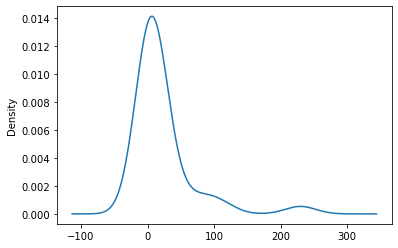

In [209]:
# Visualize the value counts of flavor_2
flavor_1_counts.plot.density()

In [210]:
# Determine which values to replace if counts are less than ...?
replace_flavor_1 = list(flavor_1_counts[flavor_1_counts < 10].index)

# Replace in dataframe
for app in replace_flavor_1:
    kushy_washington_df.flavor_1 = kushy_washington_df.flavor_1.replace(app,"Other")
    
# Check to make sure binning was successful
kushy_washington_df.flavor_1.value_counts()

Earthy       230
Sweet        112
None          90
Other         82
Citrus        73
Berry         44
Pine          25
Lemon         22
Grape         18
Blueberry     16
Skunk         10
Name: flavor_1, dtype: int64

In [211]:
# Look at flavor_2 value counts for binning
flavor_2_counts = kushy_washington_df.flavor_2.value_counts()
flavor_2_counts

None            176
 Sweet          123
 Earthy          79
 Citrus          51
 Pine            45
 Berry           36
Earthy           20
Sweet            18
 Skunk           16
Pungent          15
 Grape           14
Citrus           11
Woody            10
 Orange           7
Pine              6
Berry             6
 Blueberry        6
Spicy/Herbal      6
 Lemon            6
Skunk             5
 Strawberry       4
Flowery           4
Pepper            4
 Coffee           4
Tropical          4
Orange            4
 Lime             4
 Lavender         3
Blueberry         3
 Pineapple        3
Sage              3
Lemon             2
 Mint             2
 Pepper           2
 Mango            2
Grapefruit        2
 Honey            2
Lavender          2
 Rose             1
Diesel            1
Ammonia           1
Lime              1
Rose              1
Grape             1
Tobacco           1
 Ammonia          1
Fruit             1
Honey             1
 Apple            1
Chemical          1


<AxesSubplot:ylabel='Density'>

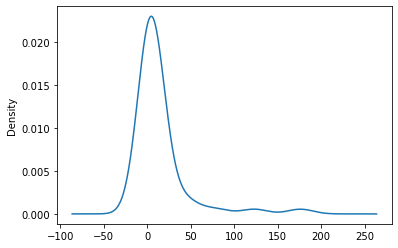

In [212]:
# Visualize the value counts of flavor_2
flavor_2_counts.plot.density()

In [213]:
# Determine which values to replace if counts are less than ...?
replace_flavor_2 = list(flavor_2_counts[flavor_2_counts < 10].index)

# Replace in dataframe
for app in replace_flavor_2:
    kushy_washington_df.flavor_2 = kushy_washington_df.flavor_2.replace(app,"Other")
    
# Check to make sure binning was successful
kushy_washington_df.flavor_2.value_counts()

None       176
 Sweet     123
Other      108
 Earthy     79
 Citrus     51
 Pine       45
 Berry      36
Earthy      20
Sweet       18
 Skunk      16
Pungent     15
 Grape      14
Citrus      11
Woody       10
Name: flavor_2, dtype: int64

In [214]:
# Look at flavor_3 value counts for binning
flavor_3_counts = kushy_washington_df.flavor_3.value_counts()
flavor_3_counts

None            424
 Sweet           52
 Earthy          30
Sweet            23
 Berry           19
 Citrus          17
 Pine            16
Earthy           14
Flowery          13
Citrus           13
Pungent          11
Woody            11
 Lemon            7
Pine              7
 Grape            7
 Blueberry        5
Spicy/Herbal      5
Tropical          5
Blueberry         4
Grapefruit        3
 Skunk            3
Lemon             3
 Lime             3
Diesel            3
Berry             3
Orange            2
Pepper            2
 Rose             2
Tree              2
Lime              1
Tea               1
Sage              1
 Coffee           1
 Strawberry       1
Chemical          1
Coffee            1
Skunk             1
Honey             1
 Pineapple        1
Grape             1
Cheese            1
Strawberry        1
Name: flavor_3, dtype: int64

<AxesSubplot:ylabel='Density'>

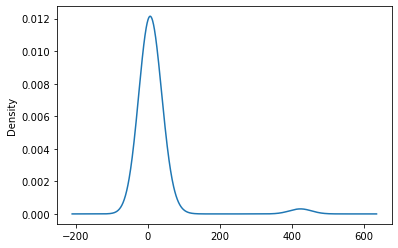

In [215]:
# Visualize the value counts of flavor_2
flavor_3_counts.plot.density()

In [216]:
# Determine which values to replace if counts are less than ...?
replace_flavor_3 = list(flavor_3_counts[flavor_3_counts < 10].index)

# Replace in dataframe
for app in replace_flavor_3:
    kushy_washington_df.flavor_3 = kushy_washington_df.flavor_3.replace(app,"Other")
    
# Check to make sure binning was successful
kushy_washington_df.flavor_3.value_counts()

None       424
Other       79
 Sweet      52
 Earthy     30
Sweet       23
 Berry      19
 Citrus     17
 Pine       16
Earthy      14
Flowery     13
Citrus      13
Pungent     11
Woody       11
Name: flavor_3, dtype: int64

In [217]:
# Check datatypes
kushy_washington_df.dtypes

type                          object
ailment_1                     object
ailment_2                     object
ailment_3                     object
ailment_4                     object
ailment_5                     object
effects_1                     object
effects_2                     object
effects_3                     object
effects_4                     object
effects_5                     object
effects_6                     object
effects_7                     object
effects_8                     object
flavor_1                      object
flavor_2                      object
flavor_3                      object
ailment_count                  int64
effects_count                  int64
flavor_count                   int64
thc_max                      float64
cbd_max                      float64
thc_cbd                      float64
cbd_thc                      float64
inventory_type                object
chemotype                      int64
strain_leafly_page_rank        int64
s

In [218]:
# Use labelencoder to encode target ailment_1 column and check datatype
le = LabelEncoder()
kushy_washington_df['ailment_1'] = le.fit_transform(kushy_washington_df['ailment_1'])
kushy_washington_df['ailment_1']

0      0
1      8
2      0
3      7
4      8
      ..
717    7
718    1
719    8
720    6
721    6
Name: ailment_1, Length: 722, dtype: int32

In [219]:
# Check datatypes
kushy_washington_df.dtypes

type                          object
ailment_1                      int32
ailment_2                     object
ailment_3                     object
ailment_4                     object
ailment_5                     object
effects_1                     object
effects_2                     object
effects_3                     object
effects_4                     object
effects_5                     object
effects_6                     object
effects_7                     object
effects_8                     object
flavor_1                      object
flavor_2                      object
flavor_3                      object
ailment_count                  int64
effects_count                  int64
flavor_count                   int64
thc_max                      float64
cbd_max                      float64
thc_cbd                      float64
cbd_thc                      float64
inventory_type                object
chemotype                      int64
strain_leafly_page_rank        int64
s

In [220]:
# Convert vector of integers to one hot encoding using keras function to_categorical
dummy_y = np_utils.to_categorical(kushy_washington_df['ailment_1'])
print(dummy_y.shape)

(722, 9)


In [221]:
# Use get_dummies() to encode object columns
kushy_washington_df_encoded = pd.get_dummies(kushy_washington_df, columns=None)
print(kushy_washington_df_encoded.shape)
kushy_washington_df_encoded.head()

(722, 191)


,ailment_1,ailment_count,effects_count,flavor_count,thc_max,cbd_max,thc_cbd,cbd_thc,chemotype,strain_leafly_page_rank,...,flavor_3_Pungent,flavor_3_Sweet,flavor_3_Woody,inventory_type_Bubble Hash,inventory_type_CO2 Hash Oil,inventory_type_Flower Lot,inventory_type_Food Grade Solvent Extract,inventory_type_Hash,inventory_type_Hydrocarbon Wax,inventory_type_Marijuana Mix
0,0,4,7,2,20.1309,0.54,37.28,0.03,1,619,...,0,0,0,0,0,1,0,0,0,0
1,8,2,7,2,9.9139,0.00,0.00,0.00,1,1276,...,0,0,0,0,0,1,0,0,0,0
2,0,2,7,1,10.8132,0.00,0.00,0.00,1,0,...,0,0,0,0,0,1,0,0,0,0
3,7,4,7,2,11.6702,0.00,0.00,0.00,1,1115,...,0,0,0,0,0,1,0,0,0,0
4,8,4,8,2,13.4657,0.00,0.00,0.00,1,708,...,0,0,0,0,0,1,0,0,0,0


In [222]:
# Split preprocessed data into features and target arrays
X = kushy_washington_df_encoded.drop(['ailment_1'],axis=1).values
y = dummy_y
# Split preprocessed data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=72)

In [223]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

### Compile, Train and Evaluate the Model

In [224]:
# Define the model - deep neural net, i.e., the number of input/output features and hidden nodes for each layer
number_input_features = X_train.shape[1]
number_output_features = y.shape[1]
hidden_nodes_layer1 = 160
hidden_nodes_layer2 = 80
hidden_nodes_layer3 = 80
hidden_nodes_layer4 = 120
hidden_nodes_layer5 = 120
hidden_nodes_layer6 = 120

nn = tf.keras.models.Sequential()

# Input and first hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="tanh"))

# Third hidden layer
# nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="tanh"))

# Fourth hidden layer
# nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer4, activation="tanh"))

# Fifth hidden layer
# nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer5, activation="tanh"))

# Sixth hidden layer
# nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer6, activation="tanh"))

# Output layer
nn.add(tf.keras.layers.Dense(units=number_output_features, activation="softmax"))

# Check the structure of the model
nn.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 160)               30560     
                                                                 
 dense_22 (Dense)            (None, 80)                12880     
                                                                 
 dense_23 (Dense)            (None, 9)                 729       
                                                                 
Total params: 44,169
Trainable params: 44,169
Non-trainable params: 0
_________________________________________________________________


In [225]:
# Import checkpoint dependencies
import os
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint path and filenames
os.makedirs("checkpoints/",exist_ok=True)
checkpoint_path = "checkpoints/weights.{epoch:02d}.hdf5"
batch_size = 17

# Compile the model
nn.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Create a callback that saves the model's weights every 5 epochs
#cp_callback = ModelCheckpoint(
#    filepath=checkpoint_path,
#    verbose=1,
#    save_weights_only=True,
#    save_freq=20*batch_size)

In [226]:
# Train the model
fit_model = nn.fit(X_train_scaled,y_train,epochs=100) # , callbacks=[cp_callback]

Epoch 1/100
17/17 [==============================] - 1s 3ms/step - loss: 1.4694 - accuracy: 0.5453
Epoch 2/100
17/17 [==============================] - 0s 3ms/step - loss: 0.7250 - accuracy: 0.7726
Epoch 3/100
17/17 [==============================] - 0s 3ms/step - loss: 0.4774 - accuracy: 0.8706
Epoch 4/100
17/17 [==============================] - 0s 2ms/step - loss: 0.3175 - accuracy: 0.9261
Epoch 5/100
17/17 [==============================] - 0s 2ms/step - loss: 0.2133 - accuracy: 0.9649
Epoch 6/100
17/17 [==============================] - 0s 3ms/step - loss: 0.1379 - accuracy: 0.9852
Epoch 7/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0928 - accuracy: 0.9982
Epoch 8/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0652 - accuracy: 0.9982
Epoch 9/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0477 - accuracy: 1.0000
Epoch 10/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0366 - accuracy: 1.0000
Epoch 11/

17/17 [==============================] - 0s 3ms/step - loss: 5.5361e-04 - accuracy: 1.0000
Epoch 83/100
17/17 [==============================] - 0s 3ms/step - loss: 5.4064e-04 - accuracy: 1.0000
Epoch 84/100
17/17 [==============================] - 0s 3ms/step - loss: 5.2828e-04 - accuracy: 1.0000
Epoch 85/100
17/17 [==============================] - 0s 3ms/step - loss: 5.1641e-04 - accuracy: 1.0000
Epoch 86/100
17/17 [==============================] - 0s 3ms/step - loss: 5.0492e-04 - accuracy: 1.0000
Epoch 87/100
17/17 [==============================] - 0s 3ms/step - loss: 4.9380e-04 - accuracy: 1.0000
Epoch 88/100
17/17 [==============================] - 0s 3ms/step - loss: 4.8298e-04 - accuracy: 1.0000
Epoch 89/100
17/17 [==============================] - 0s 3ms/step - loss: 4.7271e-04 - accuracy: 1.0000
Epoch 90/100
17/17 [==============================] - 0s 3ms/step - loss: 4.6260e-04 - accuracy: 1.0000
Epoch 91/100
17/17 [==============================] - 0s 3ms/step - loss: 4.5

In [227]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

6/6 - 0s - loss: 0.9598 - accuracy: 0.8066 - 231ms/epoch - 39ms/step
Loss: 0.9598016142845154, Accuracy: 0.8066298365592957


In [101]:
# Export our model to HDF5 file
# nn.save("MMG_DLNN.h5")